In [8]:
"""
Created on Tue Jul 25 15:45:54 2023

@author: gurasog
"""

import torch 
import gymnasium as gym 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from stable_baselines3.common.atari_wrappers import ClipRewardEnv,EpisodicLifeEnv,FireResetEnv, MaxAndSkipEnv, NoopResetEnv
import random
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Resize, InterpolationMode

In [13]:
'''TO DO

1. Check the code with other latent spaces

'''

'TO DO\n\n1. Check the code with other latent spaces\n\n'

### Utils functions

In [14]:
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    '''отрицательный слоуп постепенно снижается'''
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id, render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk

def action_to_one_hot(ind):
    one_hot=np.zeros(env.action_space.n)
    one_hot[ind]+=1
    one_hot=to_tensor(one_hot)
    return one_hot

def stack_state_and_action(state, one_hot_action):
    
    if not torch.is_tensor(state):
        state=to_tensor(state)
    if not torch.is_tensor(one_hot_action):
        one_hot_action=to_tensor(one_hot_action)
    
    return torch.hstack((state,one_hot_action))


def action_to_one_hot_table(inds):
    #inds=inds.flatten().cpu().detach().numpy()
    one_hot=np.zeros((len(inds),env.action_space.n))
    one_hot[range(len(inds)), inds]=1
    one_hot=to_tensor(one_hot)
    return one_hot



def stack_state_and_action(state, one_hot_action):
    
    if not torch.is_tensor(state):
        state=to_tensor(state)
    if not torch.is_tensor(one_hot_action):
        one_hot_action=to_tensor(one_hot_action)
    
    return torch.hstack((state,one_hot_action))
    

def to_tensor(x, dtype=torch.float32):
    try:
        x=torch.tensor(x, dtype=dtype).to(device)
    except:
        x=torch.Tensor(x, dtype=dtype).to(device)
    
    return x

downscale = Resize(size = (70, 110), interpolation = InterpolationMode.NEAREST)

def get_image(envs):    
    s_im=envs.call('render')[0].transpose(2,0,1)
    s_im=downscale(torch.Tensor(s_im))/255
    s_im=np.expand_dims(s_im, 0)
    
    return to_tensor(s_im)


### Parse parameters and hyperparameters 

In [39]:
def parse_args():
    
    class Args:
        
        def __init__(self):
            pass
        
    args_dict = dict(batch_size=128,
              buffer_size=1000000,
              capture_video=False,
              cuda=True, end_e=0.01,
              env_id='Taxi-v3',
              exp_name='DSR',
              exploration_fraction=0.1,
              gamma=0.97, hf_entity='',
              learning_rate=0.0001,
              learning_starts=50000,
              num_envs=1,
              save_model=True,
              seed=1,
              start_e=1,
              target_network_frequency=1000,
              tau=1.0,
              torch_deterministic=True,
              total_timesteps=300000,
              track=False, train_frequency=50,
              upload_model=False,
              wandb_entity=None, 
              wandb_project_name='cleanRL')
    args = Args()
    args.__dict__ = args_dict
    
    return args


### Networks

In [40]:
seed_for_env=10
env=gym.make('Taxi-v3', render_mode='rgb_array')
s, _=env.reset(seed=seed_for_env)


In [41]:
class U(nn.Module):
    def __init__(self, env, D=500):
        super().__init__()
        self.D=500
        self.network=nn.Sequential(
            nn.Linear(self.D+env.action_space.n,250),
            nn.ReLU(),
            nn.Linear(250,self.D),
            nn.ReLU(),
            nn.Linear(self.D, self.D )
            )

    def forward(self, x):
        
        output=[]
        
        if len(x)==1:
            for i in range(env.action_space.n):
                x=x.flatten()
                one_hot=action_to_one_hot(i).flatten()
                x_one_hot=stack_state_and_action(x, one_hot)
                value=self.network(x_one_hot)
                output.append(value)
            return torch.stack(output)
        else: 
            
            for i in range(env.action_space.n):
                one_hot=action_to_one_hot_table(np.full(len(x),i))
                x_one_hot=stack_state_and_action(x, one_hot)
                value=self.network(x_one_hot)
                output.append(value)
                
            return torch.stack(output).permute(1,0,2)
                
            
            
class Phi(nn.Module):
    
    def __init__(self, env, D=500):
        super().__init__()
        self.D=D
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4608, 500),
            nn.ReLU(),
            nn.Linear(500, self.D),
        )

    def forward(self, x):
        return self.network(x)
    
    
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(500,4608),
            nn.Unflatten(dim=1, unflattened_size=(32, 9, 16)),
            nn.ConvTranspose2d(32,32,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,5,2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,7,3, padding=(0,1) ),
            nn.ReLU()
            )

    def forward(self, x):
            return self.network(x)
        
        
class R(nn.Module):
    def __init__(self,  D=500):
        super().__init__()
        self.D=D
        self.network=nn.Sequential(
            nn.Linear(self.D,1, bias=False)
        )
        
    def forward(self, x):
        return self.network(x)
          


In [42]:
def get_q_values(m, weights):
    return torch.matmul(m,w.T)
    
def get_r_weights(r):
    values=[param for param in r.parameters()]
    w=values[0].data
    return w


def loss_R(obs,r, rewards, loss_fn, encoder):
    phi=encoder(obs)
    w=get_r_weights(r)
    rew_estimate=phi*w
    #print(rew_estimate.shape)
    loss=loss_fn(rew_estimate,rewards)
    return loss


def loss_FG(data, loss_fn, encoder, decoder):    
    
    encoded_data=encoder(data)
    decoded_data=decoder(encoded_data)
    loss=loss_fn(data, decoded_data)
    return loss + torch.mean(torch.square(encoded_data))


def loss_U(image_data_state,image_data_next_state,actions ,loss_fn, dones,u_net,target_u_net, gamma=0.99 ):
    
    phi=encoder(image_data_state).detach()
    phi_next=encoder(image_data_next_state).detach()
    
    with torch.no_grad():
        m_n=target_u_net.forward(x=phi_next)
        some_estimate=torch.matmul(m_n, get_r_weights(r_net).T ).squeeze()
        m_n_inds=torch.argmax(some_estimate, axis=1)
        m_n_max=m_n[torch.arange(len(m_n_inds)),m_n_inds,:]
        target=phi+gamma*m_n_max* (1 - dones)
    
    m_c=u_net.forward(x=phi)
    u_cur=m_c[torch.arange(len(phi)),actions.flatten(),:]
    #print(u_cur)
    
    return loss_fn(target,u_cur)

    
def loss_U(image_data_state,image_data_next_state,actions ,loss_fn, dones, gamma=0.99 ):
    
    phi=encoder(image_data_state).detach()
    phi_next=encoder(image_data_next_state).detach()
    
    
    m_n=u_net.forward(x=phi_next)
    some_estimate=torch.matmul(m_n, get_r_weights(r_net).T ).squeeze()
    m_n_inds=torch.argmax(some_estimate, axis=1)
    m_n_max=m_n[np.arange(len(m_n_inds)),m_n_inds,:]
    target=phi+gamma*m_n_max* (1 - dones)
    
    
    m_c=u_net.forward(x=phi)
    u_cur=m_c[range(len(phi)),actions.flatten(),:]
    #print(u_cur)
    
    return loss_fn(target,u_cur)

def rescale_reward(reward):
    reward=reward[0]
    if reward==20:
        reward_sc=1
    elif reward==-10:
        reward_sc=-0.1
    else:
        reward_sc=-0.01
        
    return np.array([reward_sc])

In [43]:

if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1" "gymnasium[atari,accept-rom-license]==0.28.1"  "ale-py==0.8.1" 
"""
        )
        
    args = parse_args()
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/baseline_DSR{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
    )
    
    
    # env setup
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"
    
    dict_of_observations={}
    
    r_net=R().to(device)
    encoder=Phi(env).to(device)
    decoder=G().to(device)
    u_net=U(env).to(device)
    target_u_net=U(env).to(device) 
    target_u_net.load_state_dict(u_net.state_dict())
    
    
    opt_R=torch.optim.Adam(r_net.parameters(), lr=args.learning_rate)    
    opt_U=torch.optim.Adam(u_net.parameters(), lr=args.learning_rate)
    params_to_optimize=[  {'params': encoder.parameters()}, {'params': decoder.parameters()}  ]
    opt_autoencoder=torch.optim.Adam(params_to_optimize, lr=0.001)
    
    '''
    Realizarion with the target network that is used to somehow simplify the computation.
    Didn't show some sigificant change in performance in comparison with the previous model. 
    
    target_network = QNetwork(envs).to(device)
    target_network.load_state_dict(q_network.state_dict())
    '''
    
    loss_r_net=nn.MSELoss()
    loss_autoencoder=nn.MSELoss() 
    loss_u_net=nn.MSELoss()
    
    
    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )
    
    start_time = time.time()
    
    obs, _ = envs.reset(seed=args.seed)
    
    for global_step in range(args.total_timesteps):
        
        # ALGO LOGIC: put action logic here
        epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            with torch.no_grad():
                encoded_obs=encoder(get_image(envs))
                w=get_r_weights(r_net)
                M_s=u_net.forward(encoded_obs)
                q_values=get_q_values(M_s, w)            
                #actions = torch.argmax(q_values, dim=1).cpu().numpy()
                actions = torch.argmax(q_values, dim=0).cpu().numpy()
        
        '''Adding observation in a dictionary to simplify the further computation'''
        if obs[0] in dict_of_observations:
            pass
        else:
            image=get_image(envs)
            dict_of_observations[obs[0]]=image
                
                
                
        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)
        rewards=rescale_reward(rewards)
        

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                # Skip the envs that are not done
                if "episode" not in info:
                    continue
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("charts/epsilon", epsilon, global_step)
        
        
        
        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(truncated):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]
                
                
        rb.add(obs, real_next_obs, actions, rewards, terminated, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs
        
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(truncated):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]
        rb.add(obs, real_next_obs, actions, rewards, terminated, infos)

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
        obs = next_obs
        


        '''Start of training'''

        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)
                
                '''Need to transform states values into the images they represent'''
                with torch.no_grad():
                    images=[dict_of_observations[int(i[0])] for i in data.observations]
                    images=torch.stack(images).squeeze()
                    images_next=[dict_of_observations[int(i[0])] for i in data.next_observations]
                    images_next=torch.stack(images_next).squeeze()
                
                loss_r_value=loss_R(images,r_net,data.rewards,loss_fn=loss_r_net, encoder=encoder)
                loss_fg_value=loss_FG(images, encoder=encoder,decoder=decoder,loss_fn=loss_autoencoder)
                loss_paired=loss_r_value+loss_fg_value
                
                '''Compute current performance for logs. Needs to be reconsidered'''
                with torch.no_grad():
                    encoded_obs=encoder(get_image(envs))
                    w=get_r_weights(r_net)
                    M_s=u_net.forward(encoded_obs)
                    q_values=get_q_values(M_s, w)
                    old_val=q_values #не совсем корректно но все же

                '''Logging'''
                if global_step % 100 == 0:
                        #print('write')
                        writer.add_scalar("losses/loss_r_value", loss_r_value, global_step)
                        writer.add_scalar("losses/loss_fg_value", loss_fg_value, global_step)
                        writer.add_scalar("losses/loss_paired", loss_paired, global_step)
                        writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                        print("SPS:", int(global_step / (time.time() - start_time)))
                        writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
                
                
                opt_R.zero_grad()
                opt_autoencoder.zero_grad()
                loss_paired.backward()
                opt_R.step()
                opt_autoencoder.step()
                '''This part is commented beacuse we use only one q-netwrok'''                
                #loss_u_value=loss_U(images, images_next, data.actions, u_net=u_net, target_u_net=target_u_net,loss_fn=loss_u_net, dones=data.dones)
                loss_u_value=loss_U(images, images_next, data.actions,loss_fn=loss_u_net, dones=data.dones)
                
                if global_step % 100 == 0:
                    writer.add_scalar("losses/loss_u_value", loss_u_value, global_step)
                    
                
                opt_U.zero_grad()
                loss_u_value.backward()
                opt_U.step()
                
                '''This part is commented beacuse we use only one q-netwrok''' 
            #if global_step % args.target_network_frequency == 0:
            #    for target_network_param, q_network_param in zip(target_u_net.parameters(), u_net.parameters()):
            #        target_network_param.data.copy_(
            #            args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
            #        )
                
                
                
    if args.save_model:
        model_path = f"runs/baseline_DSR{run_name}/{args.exp_name}.r_model"
        torch.save(r_net.state_dict(), model_path)
        
        model_path = f"runs/baseline_DSR{run_name}/{args.exp_name}.u_model"
        torch.save(u_net.state_dict(), model_path)
        
        model_path = f"runs/baseline_DSR{run_name}/{args.exp_name}.encoder_model"
        torch.save(encoder.state_dict(), model_path)
        
        model_path = f"runs/baseline_DSR{run_name}/{args.exp_name}.decoder_model"
        torch.save(decoder.state_dict(), model_path)
        
        print(f"model saved to {model_path}")
        
        '''
        episodic_returns = evaluate(
            model_path,
            make_env,
            args.env_id,
            eval_episodes=10,
            run_name=f"{run_name}-eval",
            Model=QNetwork,
            device=device,
            epsilon=0.05,
        )
        
        for idx, episodic_return in enumerate(episodic_returns):
            writer.add_scalar("eval/episodic_return", episodic_return, idx)

        if args.upload_model:
            from cleanrl_utils.huggingface import push_to_hub

            repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
            repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
            push_to_hub(args, episodic_returns, repo_id, "DQN", f"runs/{run_name}", f"videos/{run_name}-eval")
        '''
    envs.close()
    writer.close()

global_step=199, episodic_return=[-857.]
global_step=399, episodic_return=[-848.]
global_step=599, episodic_return=[-767.]
global_step=799, episodic_return=[-650.]
global_step=999, episodic_return=[-776.]
global_step=1199, episodic_return=[-785.]
global_step=1399, episodic_return=[-812.]
global_step=1599, episodic_return=[-857.]
global_step=1799, episodic_return=[-794.]
global_step=1999, episodic_return=[-902.]
global_step=2199, episodic_return=[-668.]
global_step=2399, episodic_return=[-695.]
global_step=2599, episodic_return=[-848.]
global_step=2799, episodic_return=[-650.]
global_step=2999, episodic_return=[-713.]
global_step=3199, episodic_return=[-605.]
global_step=3399, episodic_return=[-776.]
global_step=3599, episodic_return=[-686.]
global_step=3799, episodic_return=[-668.]
global_step=3999, episodic_return=[-767.]
global_step=4199, episodic_return=[-686.]
global_step=4399, episodic_return=[-659.]
global_step=4599, episodic_return=[-668.]
global_step=4799, episodic_return=[-713

In [55]:
def encode(taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
    
def decode(i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        #print(i, 'AAAAAAAAAAAAAAA')
        #assert 0 <= i < 5
        #assert (0 <= i < 5).all
        state_extended = []
        for i in reversed(out):
            state_extended.append(i)
        return state_extended
def calc_value_matrix(Q, dict_of_obs, get_r_weights, PAS_LOC, DEST_LOC, grid_dim_x = 5, grid_dim_y = 5):
    #we fix passenger location and destination location and go inside the environment
    #initialize V
    V = np.zeros((grid_dim_x, grid_dim_y)) + np.inf
    
    #go inside the grid and calculate V
    for t_x in range(grid_dim_x):
        for t_y in range(grid_dim_y):
            state = encode(t_x,t_y, torch.tensor(3), roch.tensor(1)) 
            #print(state)
            encoded_obs=dict_of_observaions[state]#recode_states(np.array([state]))
            #encoded_obs=encoder(get_image(envs))
            w=get_r_weights(r_net)
M_s=u_net.forward(encoded_obs)
q_values=get_q_values(M_s, w)
            V[t_x, t_y] = Q.max() #np.max(Q[state,:])
    return V

def plot_value_matrix(V):
    fig, ax = plt.subplots(dpi=150)
    #initialize
    for t_x in range(V.shape[0]):
        for t_y in range(V.shape[1]):
            v = V[t_x, t_y]
            ax.text(t_y, t_x, str(round(v, 1)), va='center', ha='center', fontsize=15) 
    ax.matshow(V, cmap='bwr')
    plt.show()

In [69]:
V = np.zeros((5,5)) + np.inf

#go inside the grid and calculate V
for t_x in range(5):
    for t_y in range(5):
        state = encode(t_x,t_y, torch.tensor(3), torch.tensor(1)) 
        #print(state)
        encoded_obs=dict_of_observations[int(state)]#recode_states(np.array([state]))
        encoded_obs=encoder(get_image(envs))
        w=get_r_weights(r_net)
        M_s=u_net.forward(encoded_obs)
        q_values=get_q_values(M_s, w)
        V[t_x, t_y] = q_values.max() #np.max(Q[state,:])
print(V)

[[-0.84460497 -0.84460497 -0.84460497 -0.84460497 -0.84460497]
 [-0.84460497 -0.84460497 -0.84460497 -0.84460497 -0.84460497]
 [-0.84460497 -0.84460497 -0.84460497 -0.84460497 -0.84460497]
 [-0.84460497 -0.84460497 -0.84460497 -0.84460497 -0.84460497]
 [-0.84460497 -0.84460497 -0.84460497 -0.84460497 -0.84460497]]


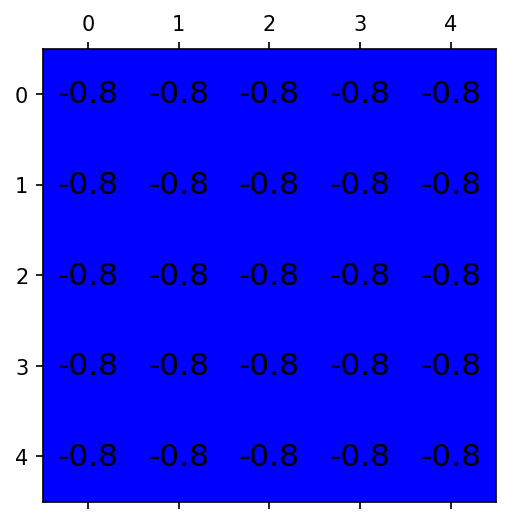

In [70]:
plot_value_matrix(V)

In [68]:
encoded_obs.shape

torch.Size([1, 3, 70, 110])

In [66]:
int(state)

13

In [46]:
envs = gym.vector.SyncVectorEnv(
        [make_env('Taxi-v3', 45+i, i, False, 'qq') for i in range(1)]
    )

s, _=envs.reset(seed=seed_for_env)

In [59]:
dict_of_observations

{252: tensor([[[[0.4314, 0.4824, 0.4824,  ..., 0.4784, 0.4784, 0.4275],
           [0.4549, 0.4235, 0.4549,  ..., 0.4588, 0.4667, 0.4588],
           [0.4549, 0.4784, 0.4118,  ..., 0.4353, 0.4549, 0.4235],
           ...,
           [0.4588, 0.5059, 0.4667,  ..., 0.5020, 0.4157, 0.5059],
           [0.4471, 0.4863, 0.4314,  ..., 0.4157, 0.5020, 0.4510],
           [0.4824, 0.4627, 0.4471,  ..., 0.4118, 0.4824, 0.4745]],
 
          [[0.4275, 0.4784, 0.4902,  ..., 0.4745, 0.4627, 0.4235],
           [0.4706, 0.4118, 0.4510,  ..., 0.4627, 0.4510, 0.4627],
           [0.4588, 0.4824, 0.4157,  ..., 0.4314, 0.4667, 0.4353],
           ...,
           [0.4431, 0.5059, 0.4588,  ..., 0.4941, 0.4235, 0.5059],
           [0.4510, 0.4941, 0.4431,  ..., 0.4235, 0.5059, 0.4549],
           [0.4706, 0.4667, 0.4353,  ..., 0.4078, 0.4667, 0.4824]],
 
          [[0.4157, 0.4863, 0.4745,  ..., 0.4784, 0.4549, 0.4196],
           [0.4510, 0.4118, 0.4471,  ..., 0.4471, 0.4627, 0.4471],
           [0.4667,

In [50]:
print(s)
print(decode(s))

[473]
[array([4]), array([3]), array([3]), array([1])]


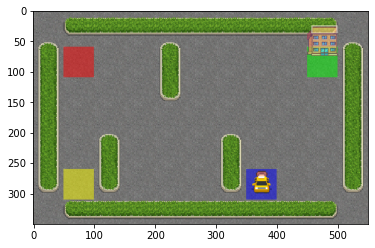

In [54]:
plt.imshow(envs.call('render')[0])

In [ ]:
encoded_obs=encoder(get_image(envs))
w=get_r_weights(r_net)
M_s=u_net.forward(encoded_obs)
q_values=get_q_values(M_s, w)

In [ ]:
encoded_obs=recode_states(obs)
q_values = q_network(torch.Tensor(encoded_obs).to(device))


In [ ]:
import matplotlib.pyplot as plt
V = calc_value_matrix(q_network, 1, 0, grid_dim_x = 5, grid_dim_y = 5)
plot_value_matrix(V)

4


NameError: name 'recode_states' is not defined